In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Context
Data from Kaggle Diamonds dataset: https://www.kaggle.com/datasets/shivam2503/diamonds

Contains data on prices and attributes of ~54k diamonds. We are predicting price. 

**Goal:**
Goal is primarily to have a playground to learn and explore different models, test my own Numpy implemented models, and practice data analysis & visualization as I continue to learn ML.

While linear regression is not the most ideal model for this dataset, I'm starting here for learning purposes.

# Loading Data, Data Visualzation, and Data Preprocessing
*Data processing portion inspired by https://www.kaggle.com/code/karnikakapoor/diamond-price-prediction

Features
* price - price in US dollars (326-18,823)
* carat - weight of the diamond (0.2--5.01)
* cut - quality of the cut (fair, good, very good, premium, ideal)
* color - diamond color, from J (worst) to D (best)
* clarity - how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* x - length in mm (0--10.74)
* y - width in mm (0--58.9)
* z - depth in mm (0--31.8)
* depth - total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
* table - width of top of diamond relative to widest point (43--95)

In [4]:
data = pd.read_csv('C:/Users/tmmet/code/machine-learning/datasets/diamonds.csv')
data.head()

Unnamed: 0  carat      cut color clarity  depth  table  price     x     y  \
0           1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98   
1           2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84   
2           3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07   
3           4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23   
4           5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35   

      z  
0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75

In [5]:
data.shape

(53940, 11)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [7]:
data.describe()

Unnamed: 0         carat         depth         table         price  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean   26970.500000      0.797940     61.749405     57.457184   3932.799722   
std    15571.281097      0.474011      1.432621      2.234491   3989.439738   
min        1.000000      0.200000     43.000000     43.000000    326.000000   
25%    13485.750000      0.400000     61.000000     56.000000    950.000000   
50%    26970.500000      0.700000     61.800000     57.000000   2401.000000   
75%    40455.250000      1.040000     62.500000     59.000000   5324.250000   
max    53940.000000      5.010000     79.000000     95.000000  18823.000000   

                  x             y             z  
count  53940.000000  53940.000000  53940.000000  
mean       5.731157      5.734526      3.538734  
std        1.121761      1.142135      0.705699  
min        0.000000      0.000000      0.000000  
25%        4.710000      4.720000      2.910000  
50%        5.700000      5.710000      3.530000  
75%        6.540000      6.540000      4.040000  
max       10.740000     58.900000     31.800000

**Data Cleaning**
* Drop index column
* Remove dimensionless, 1-D, or 2-D diamonds (as they are invalid data points)
* Remove outliers

In [8]:
# Drop index column
data = data.drop(['Unnamed: 0'], axis=1)

In [9]:
# Drop samples with x, y, or z = 0
for dim in ['x', 'y', 'z']:
    data = data.drop(data[data[dim] == 0].index)

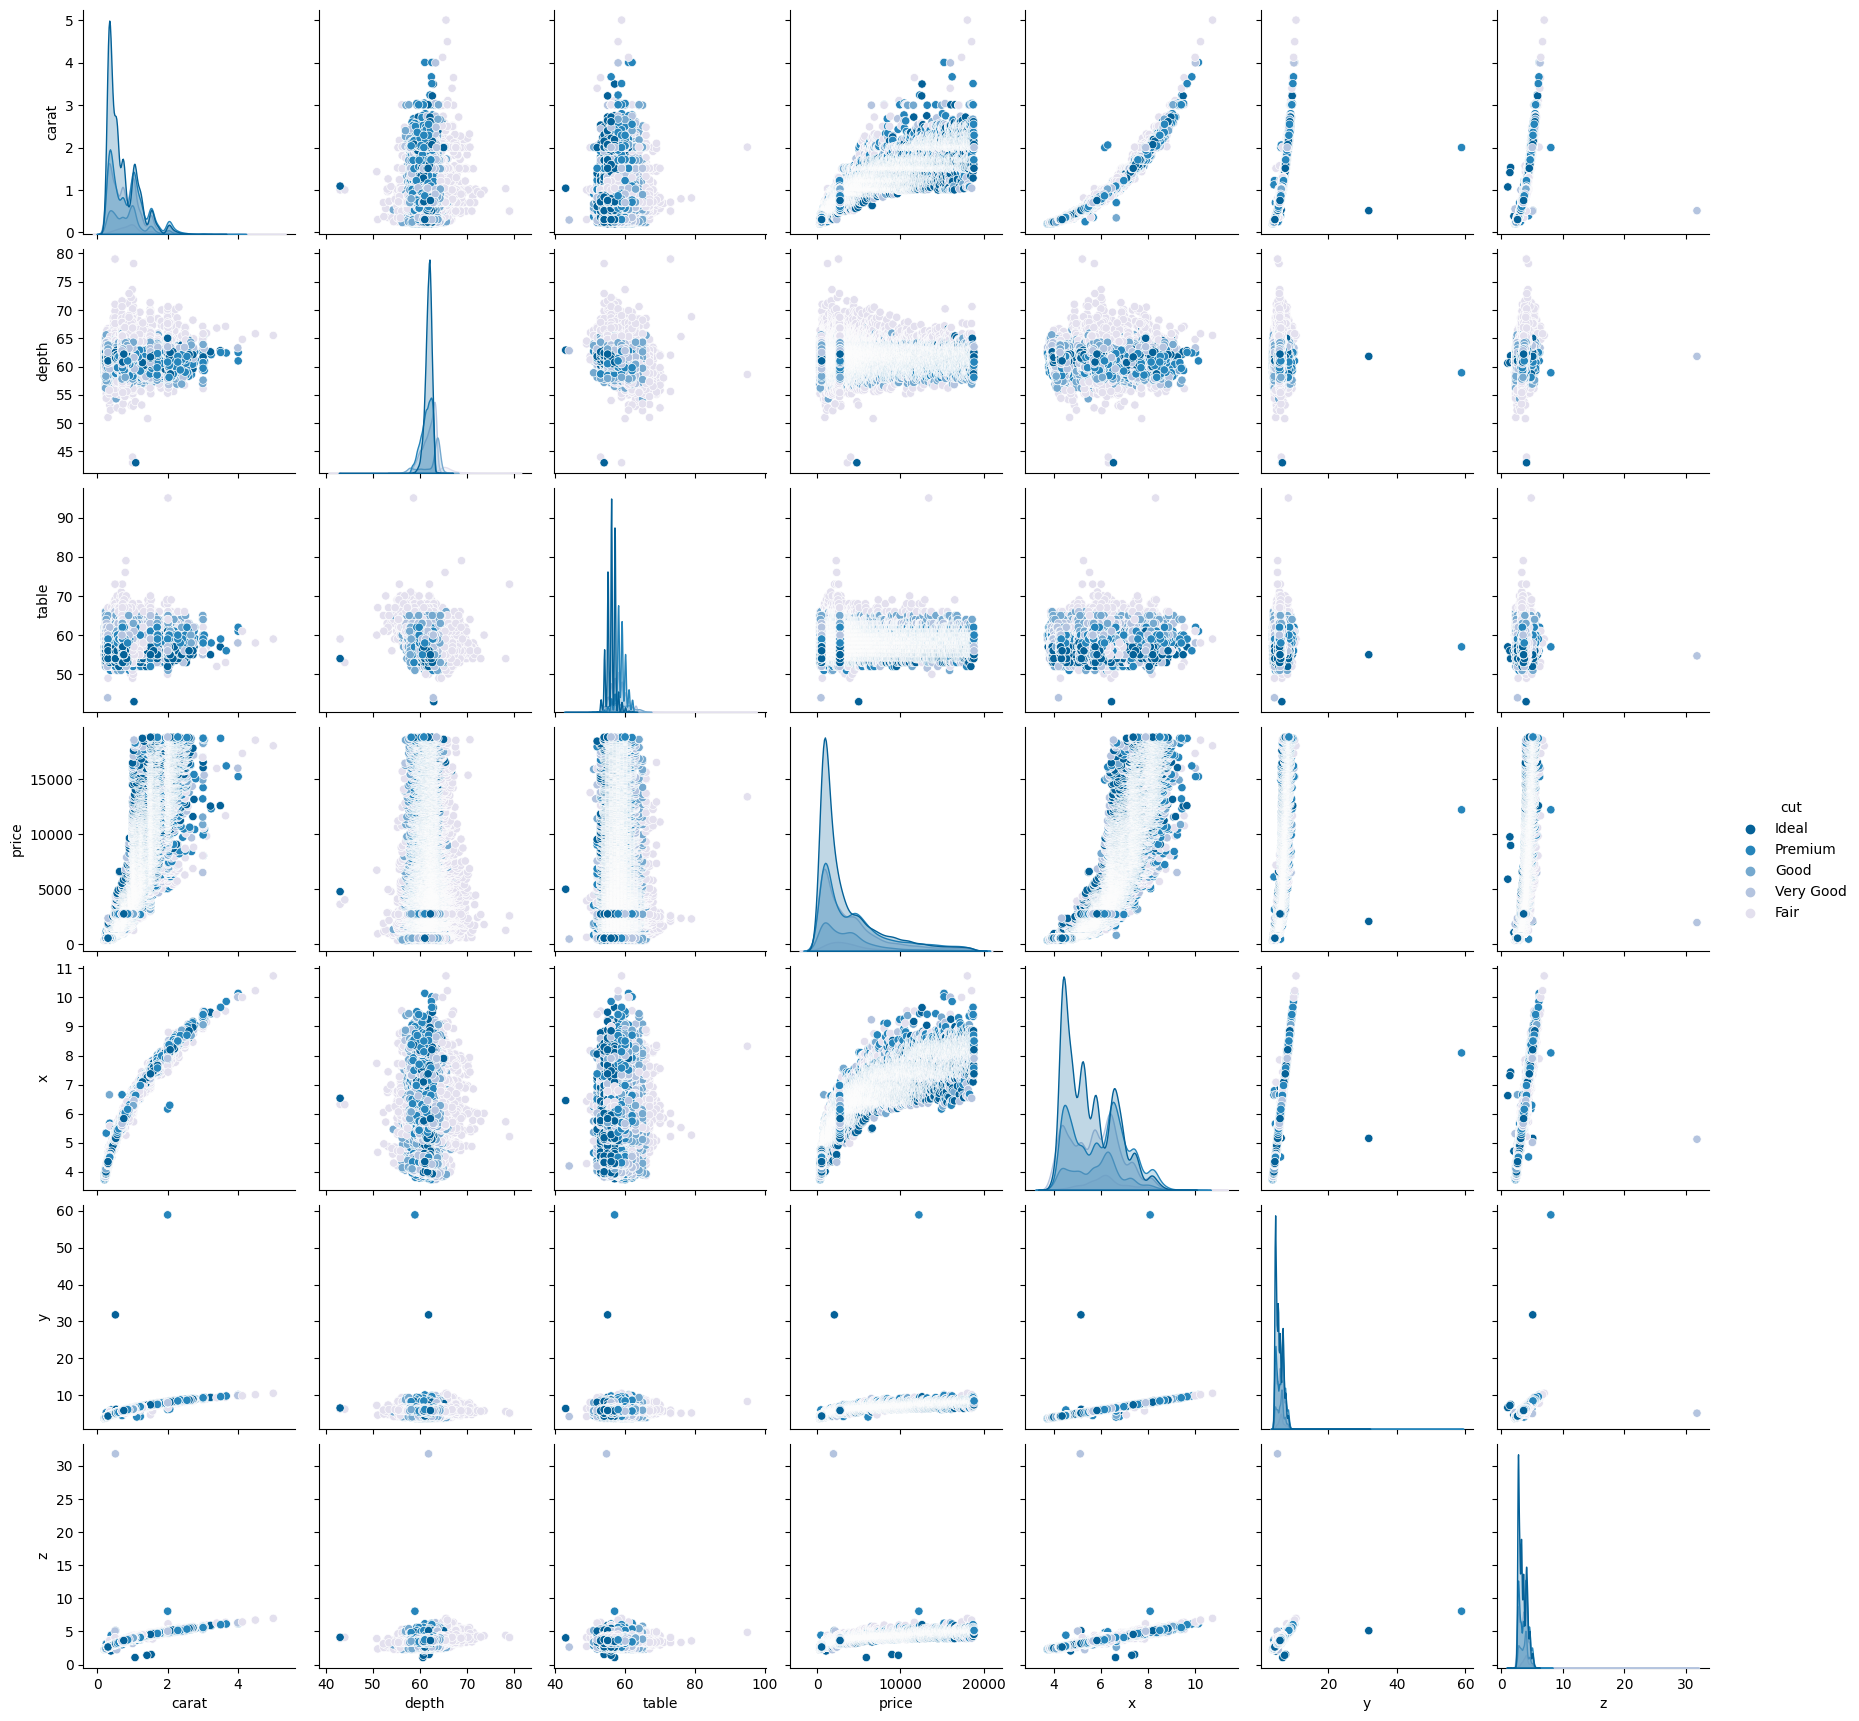

In [10]:
# Pairplot before removing outliers
ax = sns.pairplot(data, hue='cut', palette='PuBu_r')

In [11]:
# Remove outliers
data = data[(data['y'] < 25)]
data = data[(data['z'] > 2) & (data['z'] < 25)]
data = data[(data['table'] > 45) & (data['table'] < 75)]
data = data[(data['depth'] > 45) & (data['depth'] < 75)]

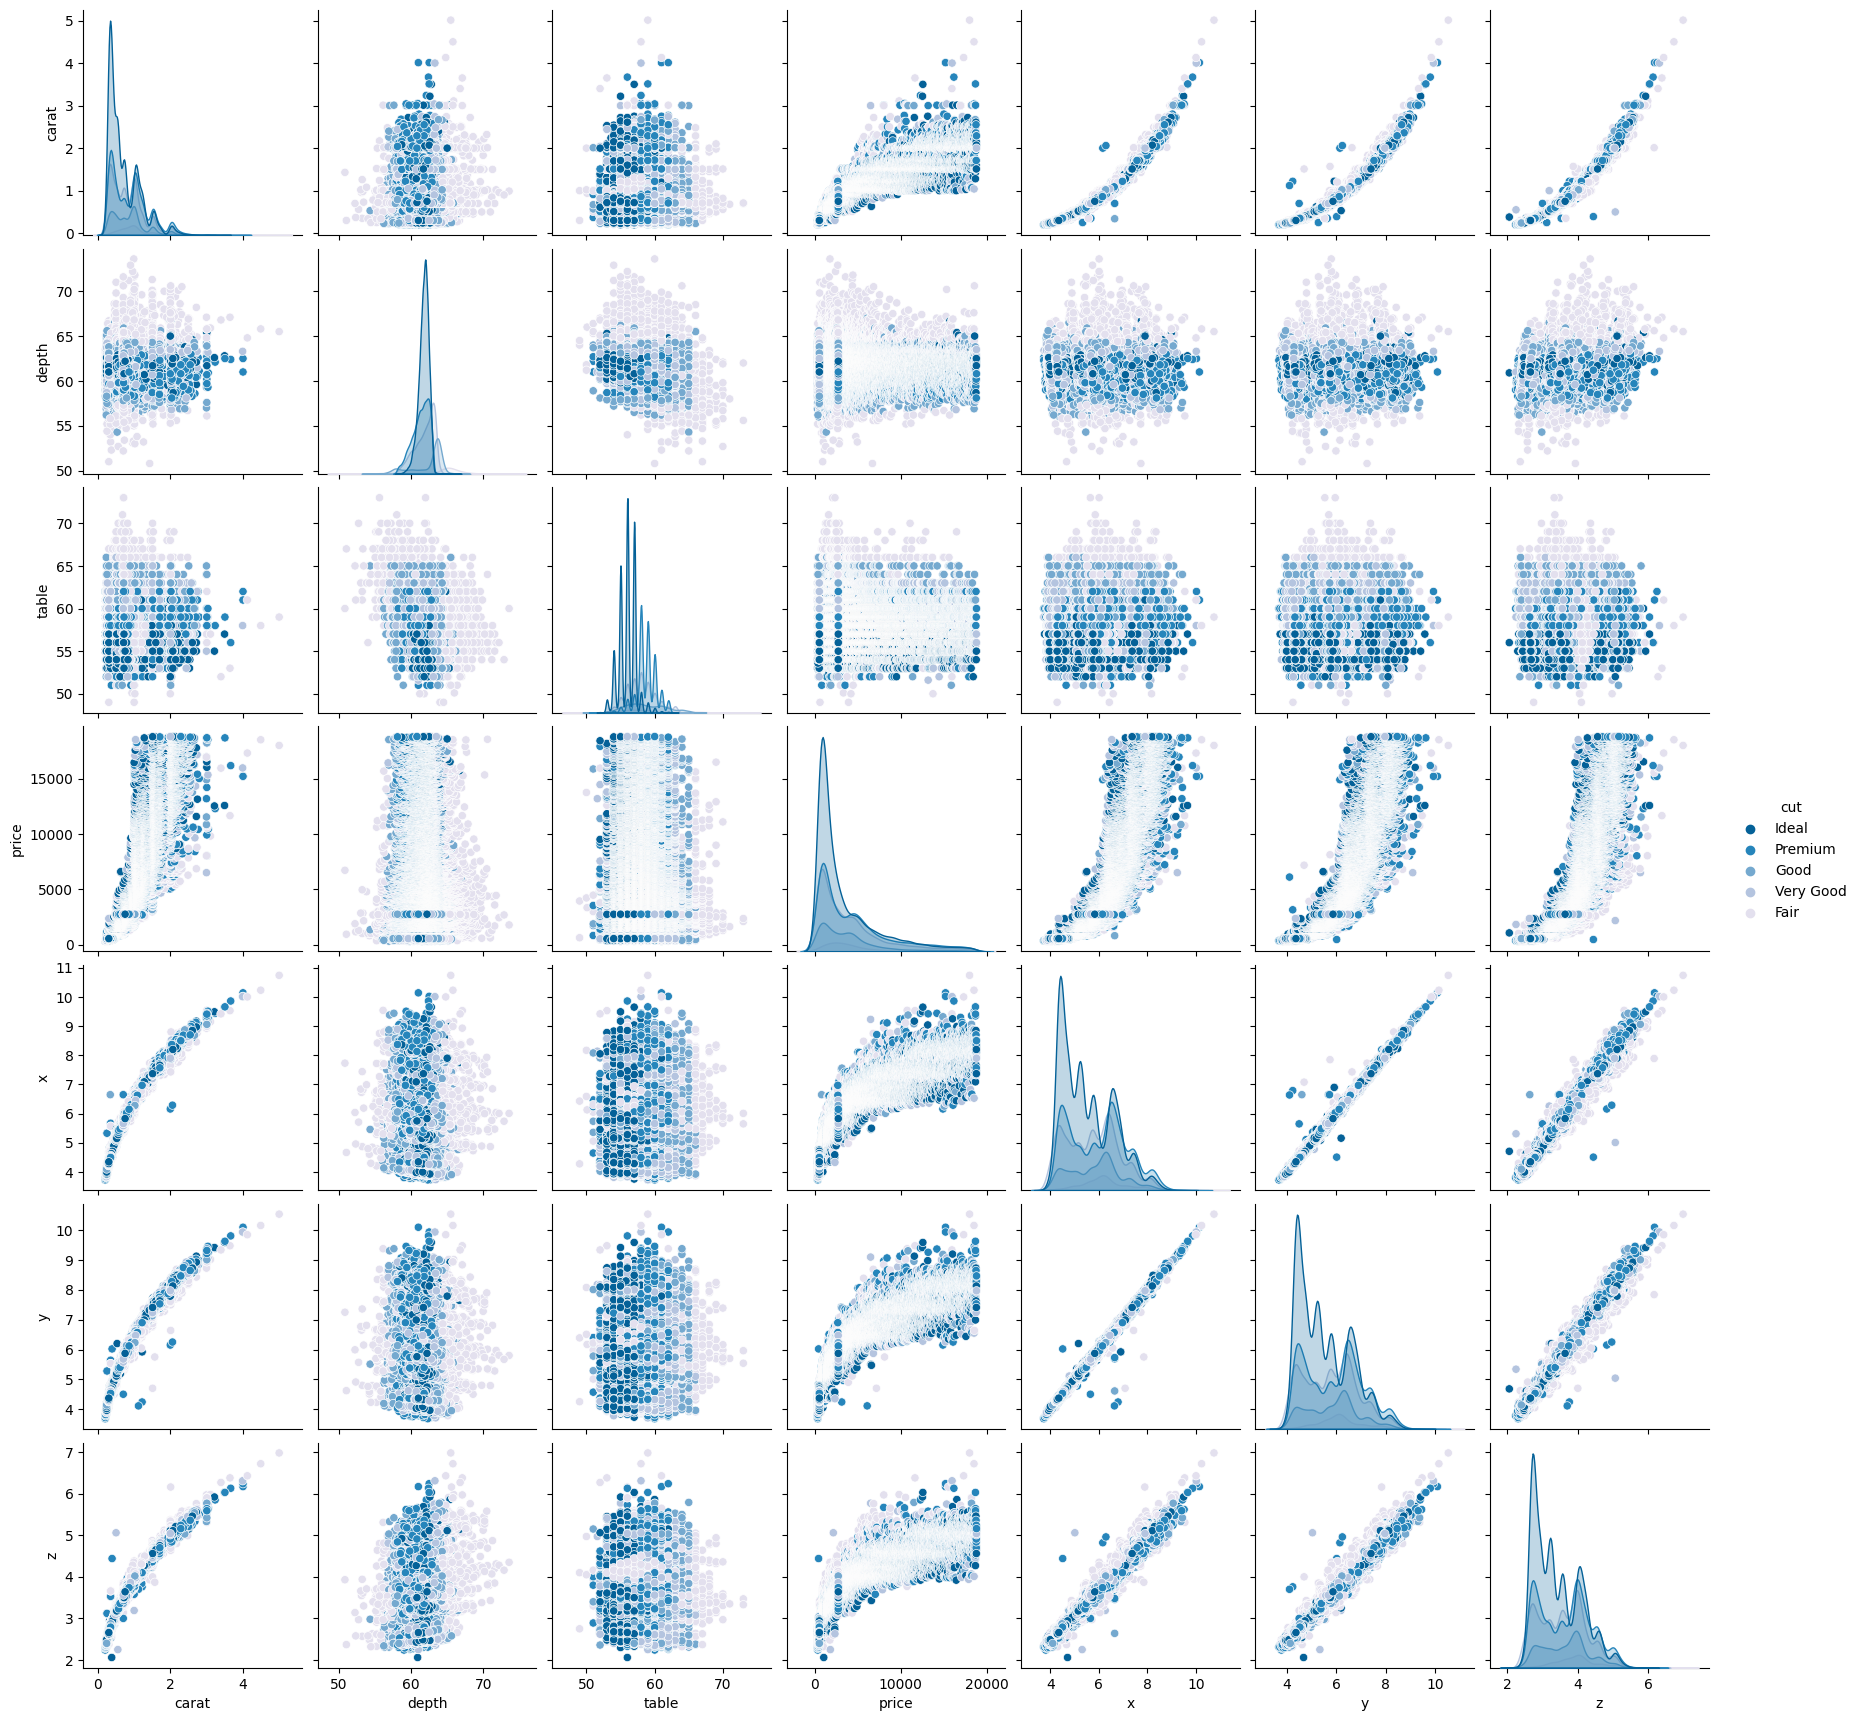

In [12]:
# Pairplot after removing outliers
ax = sns.pairplot(data, hue='cut', palette='PuBu_r')

In [13]:
# Final samples shape
data.shape

(53903, 10)

**Visualize and Encode Categorical Variables**

In [14]:
# Get the column names of categorical variables
c = data.dtypes == 'object'
categorical = list(c[c].index)
print(f'Categorical variables: {categorical}')

Categorical variables: ['cut', 'color', 'clarity']


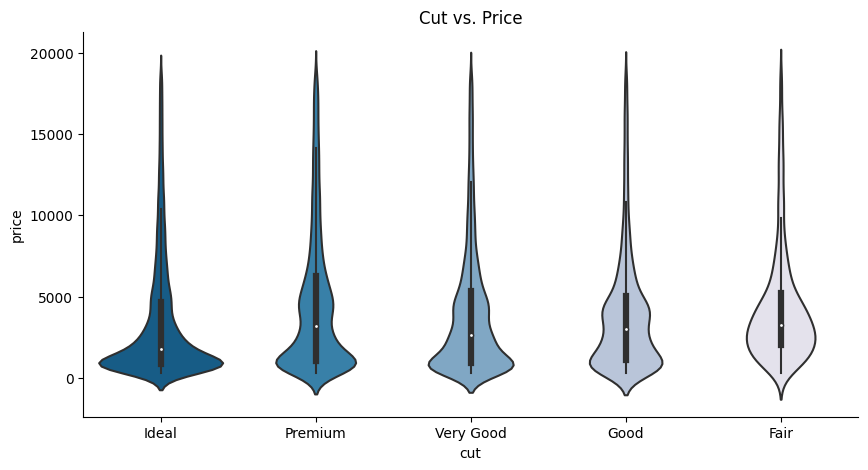

In [15]:
# Plot cut against price
plt.figure(figsize=(10,5))
plt.title('Cut vs. Price')
ax = sns.violinplot(data=data, x='cut', y='price', palette='PuBu_r', order=['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'])
ax.spines[['right', 'top']].set_visible(False)

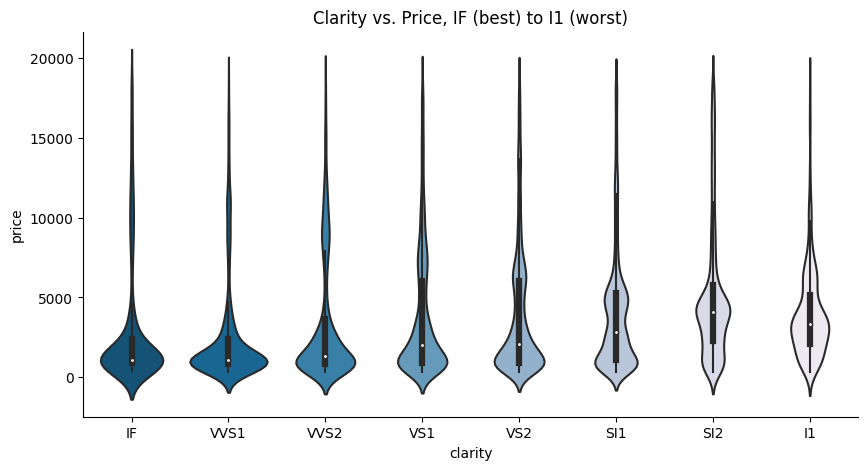

In [16]:
# Plot clarity against price
plt.figure(figsize=(10,5))
plt.title('Clarity vs. Price, IF (best) to I1 (worst)')
ax = sns.violinplot(data=data, x='clarity', y='price', palette='PuBu_r', order=['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1'])
ax.spines[['right', 'top']].set_visible(False)

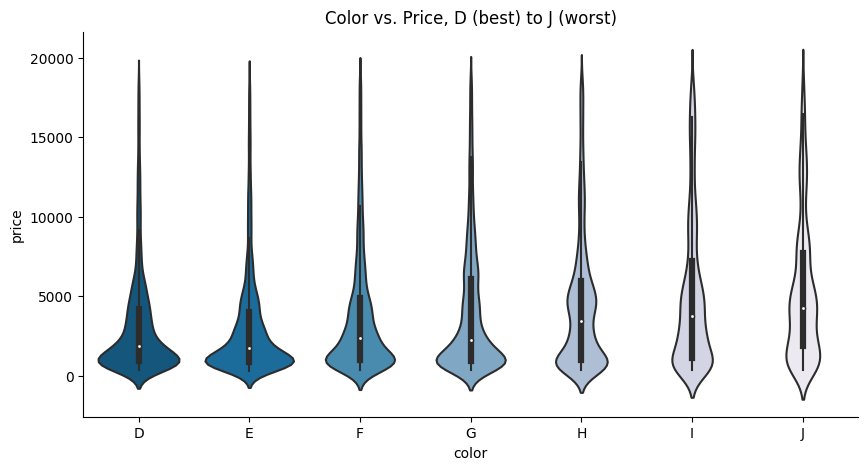

In [17]:
# Plot clarity against price
plt.figure(figsize=(10,5))
plt.title('Color vs. Price, D (best) to J (worst)')
ax = sns.violinplot(data=data, x='color', y='price', palette='PuBu_r', order=['D', 'E', 'F', 'G', 'H', 'I', 'J'])
ax.spines[['right', 'top']].set_visible(False)

In [18]:
# Encode categorical variables
encoded_data = data.copy()
le = LabelEncoder()
for c in categorical:
    encoded_data[c] = le.fit_transform(encoded_data[c])

encoded_data.head()

carat  cut  color  clarity  depth  table  price     x     y     z
0   0.23    2      1        3   61.5   55.0    326  3.95  3.98  2.43
1   0.21    3      1        2   59.8   61.0    326  3.89  3.84  2.31
2   0.23    1      1        4   56.9   65.0    327  4.05  4.07  2.31
3   0.29    3      5        5   62.4   58.0    334  4.20  4.23  2.63
4   0.31    1      6        3   63.3   58.0    335  4.34  4.35  2.75

**Correlation Matrix**

<Axes: >

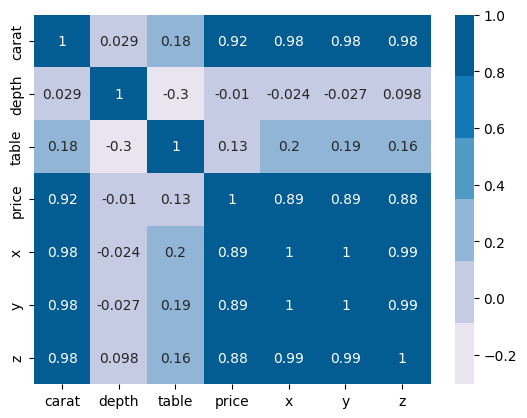

In [19]:
palette = sns.color_palette('PuBu_r')
palette.reverse()
sns.heatmap(data.corr(numeric_only=True), cmap=palette, annot=True)

**Creating Train/Test Sets**

In [20]:
# Create train/test sets
X = encoded_data.drop('price', axis=1).to_numpy()
y = encoded_data['price'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (43122, 9), y_train: (43122,)
X_test: (10781, 9), y_test: (10781,)


In [21]:
# Scale the features
# scaler = StandardScaler().fit(X_train)
# X_norm = scaler.transform(X_train)
# print(X_norm[:5])
# print(X_norm.shape)
# X_norm = np.column_stack((np.ones(X_norm.shape[0]), X_norm))

In [95]:
# Create polynomial features with degree 2
polynomial_features = PolynomialFeatures(degree=2)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.transform(X_test)
print(f'X_train_poly.shape: {X_train_poly.shape}')
print(f'X_test_poly.shape: {X_test_poly.shape}')

X_train_poly.shape: (43122, 55)
X_test_poly.shape: (10781, 55)


In [117]:
# Create log transformed features
y_train_log = np.log(y_train)
print(y_train_log[:5])
print(np.exp(y_train_log[:5]))

[6.22653667 8.34141021 5.94017125 7.42773884 7.79523493]
[ 506. 4194.  380. 1682. 2429.]


In [115]:
data.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

# Sklearn Linear Regression and Polynomial Regression

In [88]:
def plot_true_vs_predict(y, y_hat, title):
    """Plot true labels vs. predictions.
    
    Args:
        y: (n,) true labels for n samples
        y_hat: (n,) predictions for n samples
        title: (str) graph title
    """
    sns.set_style("whitegrid")
    scatter_kwargs = dict(s=1, alpha=0.8, marker="1", c='lightsteelblue')
    lims = [min(y.min(), y_hat.min()), max(y.max(), y_hat.max())]
    
    fig, ax = plt.subplots(1, 1, figsize=(9,6))
    ax.plot(lims, lims, label='Perfect prediction', c='k', ls='--')
    ax.scatter(x=y, y=y_hat, **scatter_kwargs)
    
    ax.set_xlabel('Labels')
    ax.set_ylabel('Predictions')
    ax.set_title(title)
    ax.legend()

In [118]:
def report_results(X, y, y_hat, transform):
    """Prints first five prediction and true label values as well as mean squared error 
    root mean square error, r squared.
    
    Args:
        X: (n, d) n samples with d features
        y: (n,) true labels for n samples
        y_hat: (n,) predictions for n samples
        transform: (func) transformation to apply to y_hat
    """
    y_hat_tf = transform(y_hat)
    print(f'Prediction:\n{y_hat_tf[:5]}')
    print(f'Target values:\n{y[:5]}')

    mse = mean_squared_error(y, y_hat_tf)
    rmse = np.sqrt(mse)
    print(f'\nMSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R squared: {r2_score(y, y_hat_tf)}')

**Linear regression**

In [119]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

w_lr = lr_model.coef_
b_lr = lr_model.intercept_
print(f'model parameters:\nw: {w_lr},\nb: {b_lr}')

model parameters:
w: [11147.72334312    57.69617994  -263.71827822   285.5494028
   120.41617081   -85.60867862 -1754.04889299  3388.91759575
 -4606.73852732],
b: -1109.3448179979546


X_train results:
Prediction:
[-533.25312814 4398.4421686  -311.30725069 1904.86844383 3193.93698421]
Target values:
[ 506 4194  380 1682 2429]

MSE: 1815584.5575617985
RMSE: 1347.4362907246482
R squared: 0.8862743077019339


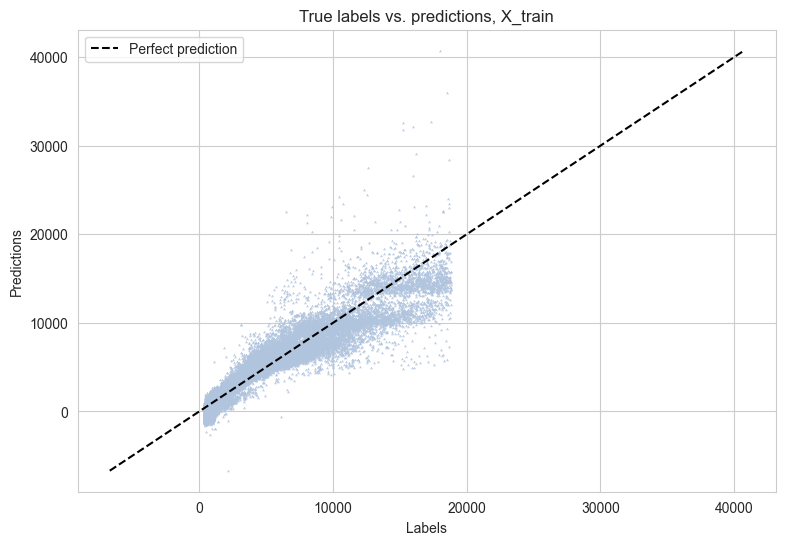

In [120]:
y_hat_train_lr = lr_model.predict(X_train)

print('X_train results:')
report_results(X_train, y_train, y_hat_train_lr, lambda y: y)
plot_true_vs_predict(y_train, y_hat_train_lr, 'True labels vs. predictions, X_train')

X_test results:
Prediction:
[1465.79365165   54.17553525 5741.80775511 1435.60605585 1901.83638523]
Target values:
[ 754 1116 4375 2016 1330]

MSE: 1724262.9058049412
RMSE: 1313.1119167096692
R squared: 0.8896860305184658


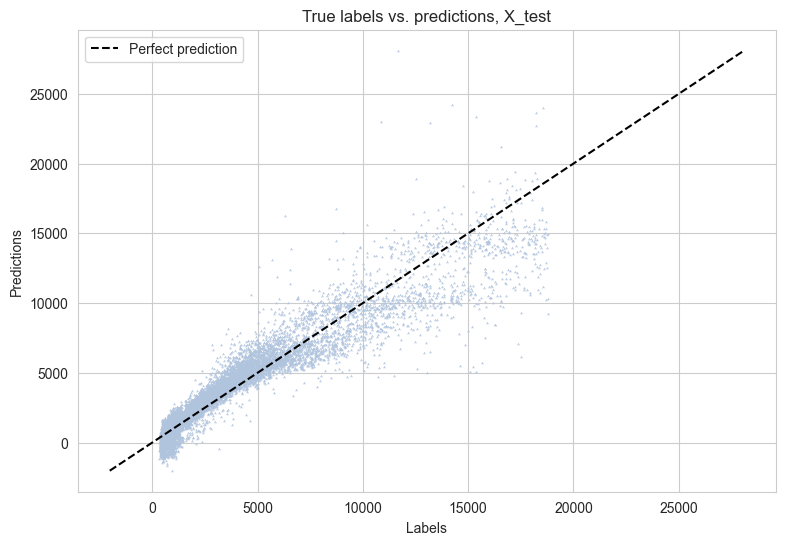

In [121]:
y_hat_test_lr = lr_model.predict(X_test)

print('X_test results:')
report_results(X_test, y_test, y_hat_test_lr, lambda y: y)
plot_true_vs_predict(y_test, y_hat_test_lr, 'True labels vs. predictions, X_test')

**Linear regression with log transformation on target**

[ 559.35436084 3627.02902653  529.21698867 ... 1033.79297052 2575.43703719
 6206.72960157]
X_train results:
Prediction:
[ 559.35436084 3627.02902653  529.21698867 2050.72840291 2863.79243715]
Target values:
[ 506 4194  380 1682 2429]

MSE: 1386075.0733932818
RMSE: 1177.3168959092034
R squared: 0.9131781846005383


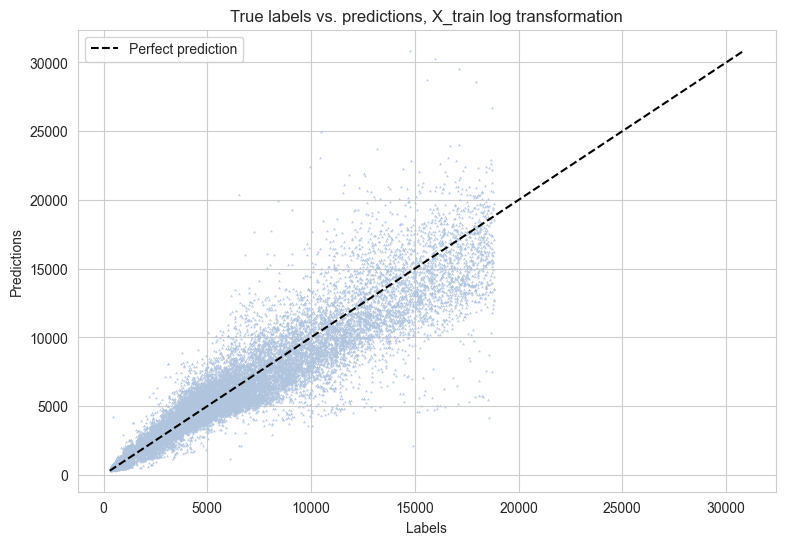

In [122]:
lr_model_log = LinearRegression()
lr_model_log.fit(X_train, y_train_log)
y_hat_train_log = lr_model_log.predict(X_train)
print(np.exp(y_hat_train_log))

print('X_train results:')
report_results(X_train, y_train, y_hat_train_log, lambda y: np.exp(y))
plot_true_vs_predict(y_train, np.exp(y_hat_train_log), 'True labels vs. predictions, X_train log transformation')

X_test results:
Prediction:
[ 825.18188065 1403.59705321 5066.21548985 2144.25528904 1357.30165965]
Target values:
[ 754 1116 4375 2016 1330]

MSE: 1326245.392602172
RMSE: 1151.627280243991
R squared: 0.9151501819867532


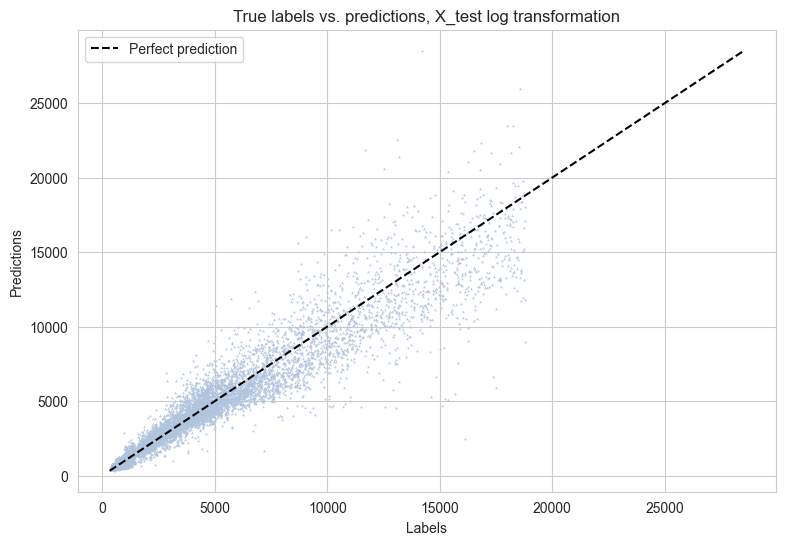

In [123]:
y_hat_test_log = lr_model_log.predict(X_test)

print('X_test results:')
report_results(X_test, y_test, y_hat_test_log, lambda y: np.exp(y))
plot_true_vs_predict(y_test, np.exp(y_hat_test_log), 'True labels vs. predictions, X_test log transformation')

**Linear regression with polynomial features**

In [124]:
pr_model = LinearRegression()
pr_model.fit(X_train_poly, y_train)

w_pr = pr_model.coef_
b_pr = pr_model.intercept_
print(f'model parameters:\nw: {w_pr},\nb: {b_pr}')

model parameters:
w: [ 6.17535269e-08 -1.63531419e+04  6.78727859e+02  2.11829218e+03
  2.66567452e+03 -1.15306361e+04  6.77155643e+02 -5.65525887e+04
 -2.38645943e+04  1.28571701e+05 -5.80976377e+03 -5.97665093e+01
 -1.39457535e+02  1.01273176e+03 -1.72528439e+02  1.82916883e+02
 -3.61268107e+03  2.48648552e+03  9.60366051e+03 -7.17722532e+01
 -6.89339345e+00 -1.14785248e+01 -1.74141876e+00 -3.92216980e+00
 -3.22686316e+02  1.51074032e+02  3.08471303e+02 -4.52140606e+01
 -6.88067314e+01 -2.02859663e+01  8.90646100e+00  4.54243774e+01
 -4.11188823e+02  3.01650528e+02  4.43351634e+01 -3.96475873e+01
 -5.10815801e+00  3.38989305e+02 -8.29260656e+02  6.39249800e+02
  9.30292293e+01 -2.54489643e+00  8.03474503e+02  4.99122858e+02
 -1.93996775e+03 -8.12069657e-01  1.59448477e+02 -2.84763385e+02
  3.65328811e+01  2.37109212e+02  1.34167483e+02 -1.17343141e+03
  2.53956675e+03 -4.62169064e+03  1.43240956e+03],
b: 333534.5595155792


Polynomial X_train results:
Prediction:
[ 934.82758575 3373.53983816 -173.28832563 1845.61585974 2551.78586214]
Target values:
[ 506 4194  380 1682 2429]

MSE: 1072251.9829644903
RMSE: 1035.4960081837546
R squared: 0.9328356266455741


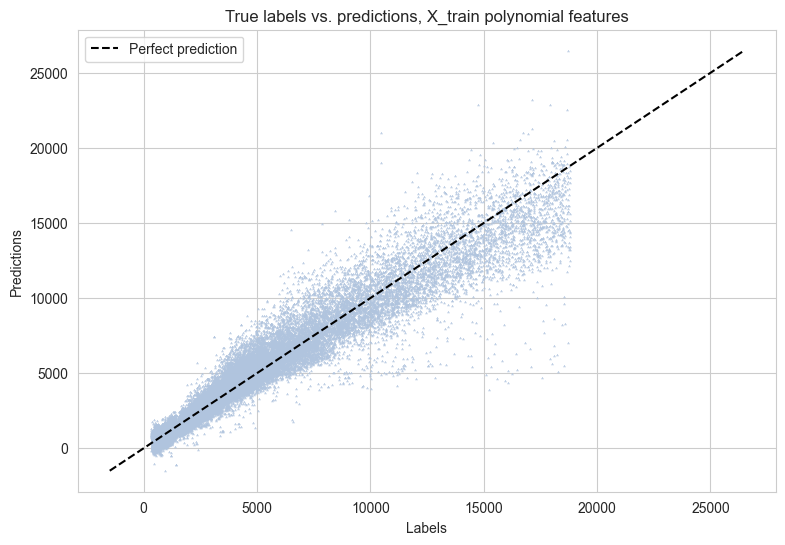

In [125]:
y_hat_train_poly = pr_model.predict(X_train_poly)

print('Polynomial X_train results:')
report_results(X_train_poly, y_train, y_hat_train_poly, lambda y: y)
plot_true_vs_predict(y_train, y_hat_train_poly, 'True labels vs. predictions, X_train polynomial features')

Polynomial X_test results:
Prediction:
[ 817.1418839  1119.37085856 5897.4002169  1670.51144781 1078.64028419]
Target values:
[ 754 1116 4375 2016 1330]

MSE: 1039521.7191770823
RMSE: 1019.5693792857269
R squared: 0.9334940357304972


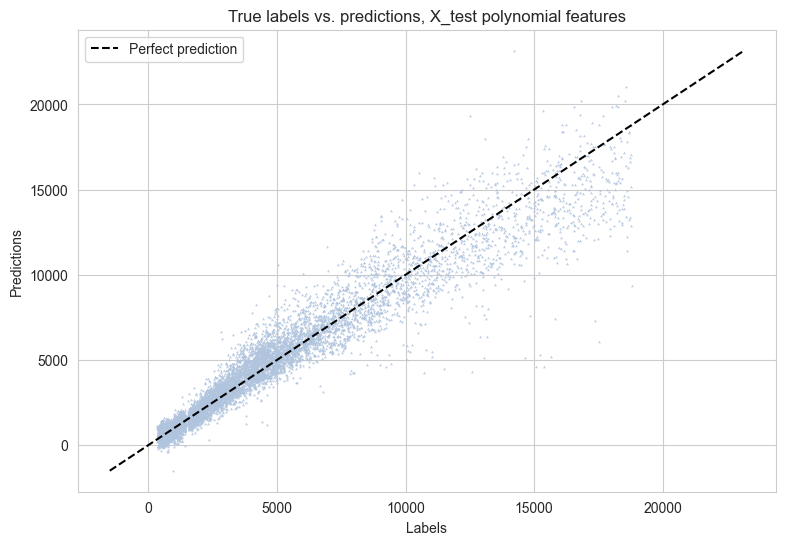

In [126]:
y_hat_test_poly = pr_model.predict(X_test_poly)

print('Polynomial X_test results:')
report_results(X_test_poly, y_test, y_hat_test_poly, lambda y: y)
plot_true_vs_predict(y_test, y_hat_test_poly, 'True labels vs. predictions, X_test polynomial features')

**Linear regression with polynomial features and log transformed target**

X_train results:
Prediction:
[ 651.48642946 3557.56194566  425.42308963 1948.31741366 2591.91985251]
Target values:
[ 506 4194  380 1682 2429]

MSE: 1018946.9127766134
RMSE: 1009.4290033363483
R squared: 0.9361745821268073


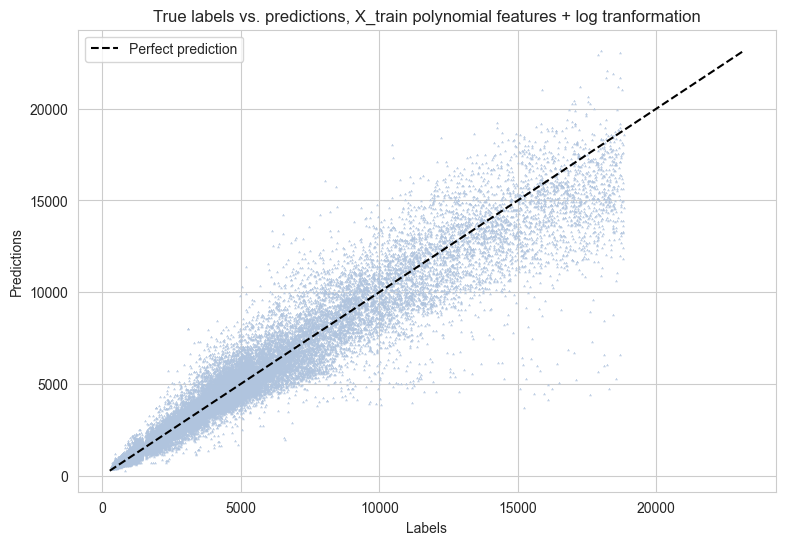

In [127]:
pr_model_log = LinearRegression()
pr_model_log.fit(X_train_poly, y_train_log)
y_hat_train_poly_log = pr_model_log.predict(X_train_poly)

print('X_train results:')
report_results(X_train_poly, y_train, y_hat_train_poly_log, lambda y: np.exp(y))
plot_true_vs_predict(y_train, np.exp(y_hat_train_poly_log),\
                     'True labels vs. predictions, X_train polynomial features + log tranformation')

Polynomial X_test results:
Prediction:
[ 774.50827166 1281.96480525 5624.98361683 1851.31175631 1203.19715964]
Target values:
[ 754 1116 4375 2016 1330]

MSE: 1382320.492265115
RMSE: 1175.721264698872
R squared: 0.911562639268026


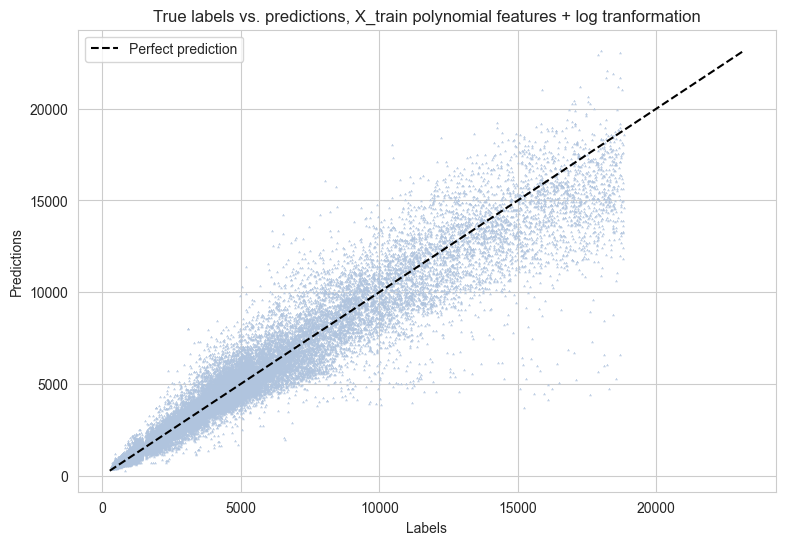

In [128]:
y_hat_test_poly_log = pr_model_log.predict(X_test_poly)

print('Polynomial X_test results:')
report_results(X_test_poly, y_test, y_hat_test_poly_log, lambda y: np.exp(y))
plot_true_vs_predict(y_train, np.exp(y_hat_train_poly_log),\
                     'True labels vs. predictions, X_train polynomial features + log tranformation')